In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, classification_report
import pickle
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize

# Download stopwords if not already downloaded
#nltk.download('stopwords')

# Load dataset
df = pd.read_csv('training_data_lowercase.csv', sep='\t', names=['label', 'text'])

# Check and clean dataset
#df.dropna(subset=['text', 'label'], inplace=True)

# Preprocess text (lowercasing, removing punctuation, and stopwords)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    #stop_words = set(stopwords.words('english'))
    #return ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned_text'] = df['text'].apply(preprocess_text)

# Vectorize text using TF-IDF
""" tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['label'] """

#Defining target and features
X = df['cleaned_text']
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def tokenize(phrase):
    return [word for word in word_tokenize(phrase)]
X_train_tk = X_train.apply(tokenize)
X_test_tk = X_test.apply(tokenize)

# Train the Word2Vec model
w2v_model = Word2Vec(sentences=X_train_tk, vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_train_vect = X_train_tk.apply(lambda sentence: get_sentence_vector(sentence, w2v_model))
X_test_vect = X_test_tk.apply(lambda sentence: get_sentence_vector(sentence, w2v_model))

# Initialize and train the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(list(X_train_vect), y_train)

# Make predictions
y_pred = logreg_model.predict(list(X_test_vect))

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

""" Save the Logistic Regression model and the TF-IDF vectorizer for future use
with open('logreg_model.pkl', 'wb') as f:
    pickle.dump(logreg_model, f)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f) """




Accuracy: 0.8864002342263212
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3529
           1       0.88      0.88      0.88      3302

    accuracy                           0.89      6831
   macro avg       0.89      0.89      0.89      6831
weighted avg       0.89      0.89      0.89      6831



" Save the Logistic Regression model and the TF-IDF vectorizer for future use\nwith open('logreg_model.pkl', 'wb') as f:\n    pickle.dump(logreg_model, f)\n\nwith open('tfidf_vectorizer.pkl', 'wb') as f:\n    pickle.dump(tfidf, f) "

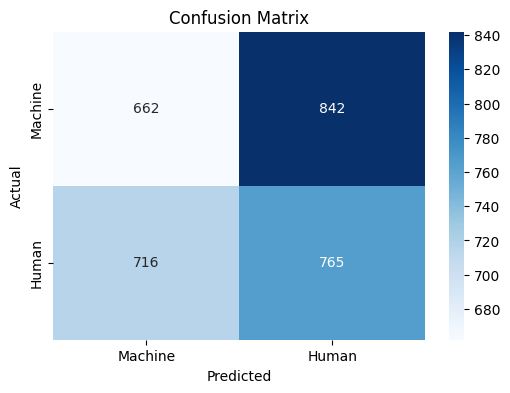

In [6]:
# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Machine', 'Human'], yticklabels=['Machine', 'Human'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

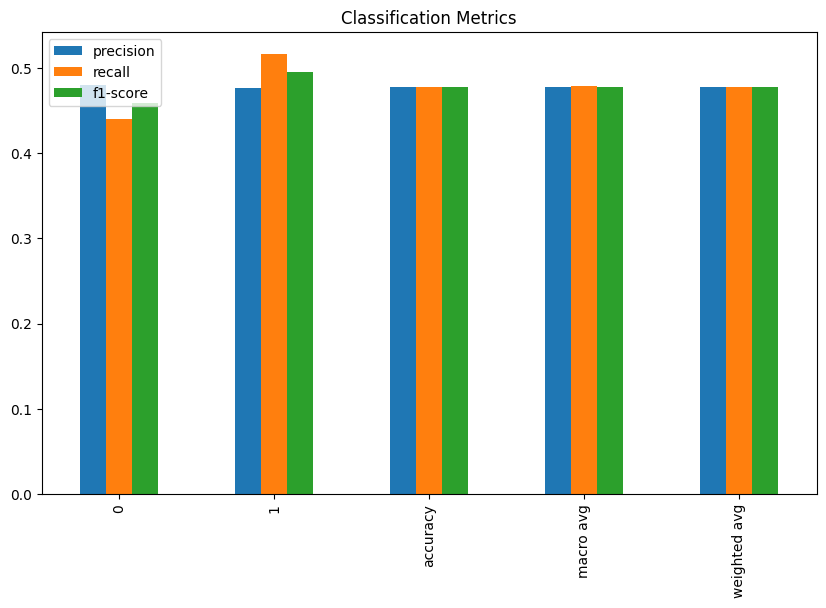

In [7]:

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot the classification report
df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Classification Metrics')
plt.show()

In [8]:
# Display a few actual vs predicted examples
for i in range(5):
    print(f"Text: {df['text'].iloc[i]}")
    print(f"Actual Label: {y_test.iloc[i]} | Predicted Label: {y_pred[i]}")
    print("-" * 50)

Text: Cuando conocí a Janice en 2013 , una familia necesitaba 600 puntos , en promedio , para ser asignada a un apartamento del ayuntamiento de Camden .
Actual Label: 0 | Predicted Label: 1
--------------------------------------------------
Text: Hwang habló en Sur de este año por Southwest Music and Media Conference sobre el tema de " videos caseros-lanzallamas " en YouTube .
Actual Label: 0 | Predicted Label: 1
--------------------------------------------------
Text: Usted podría pensar Katy Perry y Robert Pattinson reencontrándose en Coachella es una gran noticia , ¡ hasta que es coronado por quién se toparon !
Actual Label: 0 | Predicted Label: 0
--------------------------------------------------
Text: Cualquiera que haya volado los cielos del creador ha escuchado todo el acto del prevuelo con la información de seguridad hasta ahora , pero esta empleada ha volteado el guión un poco !
Actual Label: 1 | Predicted Label: 1
--------------------------------------------------
Text: Bueno

In [3]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

# Get the importance of words from the model's coefficients
top_n = 10  # Number of top words to display
sorted_items = logreg_model.coef_[0].argsort()  # Sort the coefficients by importance

# Get the feature names (words)
feature_names = tfidf.get_feature_names_out()

# Display top words for class 0 (e.g., machine-translated sentences)
print(f"Top {top_n} words for Machine-translated sentences:")
for i in sorted_items[:top_n]:
    print(f"{feature_names[i]}")

# Display top words for class 1 (e.g., human-translated sentences)
print(f"\nTop {top_n} words for Human-translated sentences:")
for i in sorted_items[-top_n:]:
    print(f"{feature_names[i]}")



Top 10 words for Machine-translated sentences:
caja
usted
acciones
inicio
través
tomar
formas
tierra
edad
superior

Top 10 words for Human-translated sentences:
enorme
pasa
unas
west
reunión
one
startup
solo
puedes
box
